## Skill Gap Analysis and Career Recommendations




In this section, we load the cleaned and merged dataset prepared during the data preprocessing phase. This dataset includes job postings enriched with skill indicators, job summaries, metadata, and classification labels.

Steps:

Initialized a PySpark session for distributed processing.
Loaded the merged_jobpredict_data_csv file using absolute path handling.
Inferred schema and printed column types and structure.
Identified all binary skill indicator columns (e.g., has_communication, has_sales).

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Start Spark session
spark = SparkSession.builder \
    .appName("JobMarketModeling") \
    .getOrCreate()

# Get absolute path to merged CSV file
merge_data_path = "file://" + os.path.abspath("merged_jobpredict_data_csv/part-00000-3399ea3a-3415-4091-bc20-e45a4abc956a-c000.csv")

# Load the CSV
df = spark.read.csv(merge_data_path, header=True, inferSchema=True)
print(df)


DataFrame[job_link: string, last_processed_time: string, got_summary: string, got_ner: string, is_being_worked: string, job_title: string, company: string, job_location: string, first_seen: string, search_city: string, search_country: string, search_position: string, job_level: string, job_type: string, first_seen_date: date, job_skills: string, job_summary: string, country: string, city: string, has_communication: int, has_customer_service: int, has_teamwork: int, has_communication_skills: int, has_leadership: int, has_problem_solving: int, has_time_management: int, has_attention_to_detail: int, has_project_management: int, has_problemsolving: int, has_sales: int, has_interpersonal_skills: int, has_data_analysis: int, has_microsoft_office_suite: int, has_organizational_skills: int, has_collaboration: int, has_analytical_skills: int, has_training: int, has_microsoft_office: int, has_adaptability: int, has_patient_care: int, has_multitasking: int, has_inventory_management: int, has_flex

In [2]:
df.printSchema()
print("Row count:", df.count())
df.show(5, truncate=False)

# List skill indicator columns
skill_cols = [col for col in df.columns if col.startswith("has_")]
print("Skill columns:", skill_cols)


root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- first_seen_date: date (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- job_summary: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- has_communication: integer (nullable = true)
 |-- has_customer_service: integer (nullable = true)
 |-- has_teamwork: integer (nullable = true)
 |-- has_communication_skills: integer 

## Skill Clustering

###  KMeans Clustering on Skill Vectors (User-Level)

This section performs KMeans clustering on user-level skill profiles derived from binary `has_` indicators. The goal is to group similar skillsets together to support downstream recommendations (e.g., career pathing or skill gap analysis).

#### **Steps:**

1. **Skill Feature Selection:**
   All columns starting with `has_` (e.g., `has_excel`, `has_leadership`) are used as binary indicators of a user's skill set.

2. **Filtering Users with Skills:**
   Only users with at least one skill marked as present (`== 1`) are included. This avoids clustering noise from empty profiles.

3. **Vector Assembly:**
   A `VectorAssembler` transforms the binary skill indicators into a single feature vector column named `"features"` — required input format for MLlib clustering.

4. **Downsampling:**
   To speed up training and avoid memory overload, the dataset is downsampled to 2% of eligible rows.

5. **KMeans Clustering:**
   A KMeans model with `k=5` and `maxIter=10` is trained to group similar skill profiles into 5 clusters.

6. **Result:**
   After fitting, the cluster assignments are added via `model.transform()` and previewed using `show()`.

#### **Purpose:**

This clustering helps in understanding major patterns in the workforce's skill profiles — allowing for cluster-based analysis, similarity recommendations, or targeted upskilling strategies.




---

#### Sample Output: Cluster Assignments for Skill Profiles

After training the KMeans model, the `clustered_df.show()` command reveals how individual user skill vectors have been assigned to clusters. Here's what this output tells us:

| Column     | Description                                                                                                                                                                      |
| ---------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `features` | A sparse vector showing which skills are present for a user (e.g., index 2, 23, and 29 are set to 1.0). The vector length corresponds to the number of skill columns (e.g., 30). |
| `cluster`  | The cluster number (0–4 in this case, since `k=5`) that the KMeans model assigned this user profile to, based on similarity to the cluster center.                               |

#### **Example Breakdown:**

* `(30,[2,23,29],[1.0,1.0,1.0])` → The user has 3 skills (at indices 2, 23, and 29). This profile belongs to cluster **0**.
* `(30,[0,3,7],[1.0,1.0,1.0])` → Another user with different skill indices is assigned to cluster **3**.
* `(30,[1,2,4,10,12,15,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])` → A richer skill profile mapped to cluster **1**.

#### **Interpretation:**

* Each cluster represents a group of users with similar skill combinations.
* Clusters can later be analyzed to understand dominant skills, common missing skills, or to make role transition recommendations.





In [3]:


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
import time

# 1. Select skill columns
skill_cols = [c for c in df.columns if c.startswith("has_")]

# 2. Filter rows with at least one skill = 1
df_skills = df.select(skill_cols).na.fill(0)
df_skills = df_skills.filter(
    sum([col(c) for c in skill_cols]) > 0
)

# 3. Assemble features
assembler = VectorAssembler(inputCols=skill_cols, outputCol="features")
df_features = assembler.transform(df_skills).select("features")

# 4. Downsample aggressively (try 2%)
df_sample = df_features.sample(fraction=0.02, seed=42)

# 5. Time and run KMeans
start_time = time.time()

# k = 5
# kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
kmeans = KMeans(k=5, seed=42, maxIter=10, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(df_sample)

elapsed = time.time() - start_time
print(f"⚡ KMeans completed in {elapsed:.2f} seconds")
# Run prediction on the sample
clustered_df = model.transform(df_sample)
clustered_df.show(5, truncate=False)






⚡ KMeans completed in 2401.38 seconds
+------------------------------------------------------+-------+
|features                                              |cluster|
+------------------------------------------------------+-------+
|(30,[2,23,29],[1.0,1.0,1.0])                          |0      |
|(30,[0,3,7],[1.0,1.0,1.0])                            |3      |
|(30,[0,1,5],[1.0,1.0,1.0])                            |1      |
|(30,[0,1,3,5,18],[1.0,1.0,1.0,1.0,1.0])               |3      |
|(30,[1,2,4,10,12,15,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|1      |
+------------------------------------------------------+-------+
only showing top 5 rows



### Cluster Center Skill Breakdown
This section extracts the learned KMeans cluster centers and interprets them by identifying the top 5 skills most representative of each cluster.

model.clusterCenters() returns the average skill vector for each cluster.

Each row in center_df shows the importance (weight) of each skill in that cluster.

For every cluster, the top 5 highest-weighted skills are printed to help understand what skills define that group.

This helps explain what each cluster means in human terms — e.g., Cluster 2 might represent tech-heavy roles if top skills include has_data_analysis, has_excel, etc.


In [4]:


# Convert cluster centers to interpretable format
import pandas as pd
import numpy as np

print("loading.....")
centers = model.clusterCenters()
center_df = pd.DataFrame(centers, columns=skill_cols)

# Show top 5 skills per cluster
for i, row in center_df.iterrows():
    top_skills = row.sort_values(ascending=False).head(5)
    print(f"\n Cluster {i}:")
    for skill, weight in top_skills.items():
        print(f"  - {skill}: {weight:.2f}")


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


loading.....

 Cluster 0:
  - has_communication: 0.31
  - has_leadership: 0.18
  - has_patient_care: 0.17
  - has_project_management: 0.14
  - has_collaboration: 0.13

 Cluster 1:
  - has_communication: 0.95
  - has_customer_service: 0.89
  - has_leadership: 0.49
  - has_sales: 0.44
  - has_teamwork: 0.44

 Cluster 2:
  - has_training: 1.00
  - has_communication: 0.33
  - has_leadership: 0.25
  - has_customer_service: 0.14
  - has_scheduling: 0.13

 Cluster 3:
  - has_communication: 1.00
  - has_communication_skills: 0.65
  - has_teamwork: 0.35
  - has_problemsolving: 0.29
  - has_leadership: 0.18

 Cluster 4:
  - has_organization: 0.95
  - has_communication: 0.93
  - has_organizational_skills: 0.58
  - has_time_management: 0.46
  - has_communication_skills: 0.39


## 🔍 Skill Gap Analysis

In this section we computed a pairwise skill gap matrix between clusters identified in the skill clustering step. Each cluster represents a group of job postings with similar skill profiles.

For each (From Cluster → To Cluster) pair, we identified the **top 5 skills** with the highest increase in presence, helping us understand:

- What skills are **missing or underrepresented** in a given cluster.
- What skills are **required** for transitioning from one group of jobs to another.

### Example Insight:
To move from **Cluster 0 to Cluster 1**, the largest skill gaps are:
- `has_leadership` (+0.939)
- `has_training` (+0.195)
- `has_problem_solving` (+0.179)

This suggests that Cluster 1 roles emphasize **leadership and training** far more than Cluster 0 roles.

We can use these gaps to:
- Recommend **career development paths**
- Guide **upskilling strategies**
- Highlight **transferable skills** between roles


In [5]:
# Calculate pairwise skill gaps
skill_gap_matrix = {}

for i in range(len(center_df)):
    for j in range(len(center_df)):
        if i != j:
            diff = center_df.iloc[j] - center_df.iloc[i]
            top_gap_skills = diff.sort_values(ascending=False).head(5)
            skill_gap_matrix[(i, j)] = top_gap_skills

# Format into DataFrame
skill_gap_summary = []
for (from_cluster, to_cluster), gap_series in skill_gap_matrix.items():
    for skill, gap in gap_series.items():
        skill_gap_summary.append({
            "From Cluster": from_cluster,
            "To Cluster": to_cluster,
            "Skill": skill,
            "Gap": round(gap, 3)
        })

skill_gap_df = pd.DataFrame(skill_gap_summary)
skill_gap_df.head(20)


,From Cluster,To Cluster,Skill,Gap
0,0,1,has_customer_service,0.777
1,0,1,has_communication,0.647
2,0,1,has_teamwork,0.399
3,0,1,has_sales,0.340
4,0,1,has_leadership,0.306
5,0,2,has_training,1.000
6,0,2,has_leadership,0.069
7,0,2,has_scheduling,0.054
8,0,2,has_teamwork,0.052
9,0,2,has_problemsolving,0.035


This section generates natural-language recommendations to help users move from their current skill cluster to others with higher demand or opportunity.

For each cluster, we identify top skills that are significantly more common in other clusters.
These skills represent gaps that, if addressed, can improve the chances of transitioning into more advanced, versatile, or better-aligned career paths.
Recommendations are sorted by impact, prioritizing the most critical skill gaps.
Use these insights to:

Design personal learning plans for career growth.
Suggest reskilling programs tailored to specific job market shifts.
Create personalized job seeker tools that match current capabilities with emerging opportunities.

In [6]:
# Group recommendations by source cluster
grouped = skill_gap_df.groupby("From Cluster")

for from_cluster, group in grouped:
    print(f"\n Career Pathways from Cluster {from_cluster}:\n")
    
    # Sort by largest skill gaps
    top_recs = group.sort_values(by="Gap", ascending=False)

    for _, row in top_recs.iterrows():
        to_cluster = row['To Cluster']
        skill = row['Skill'].replace("has_", "").replace("_", " ").title()
        gap = row['Gap']
        print(f"To move to Cluster {to_cluster}, strengthen your skill in **{skill}** — it's {gap:.0%} more common there.")



 Career Pathways from Cluster 0:

To move to Cluster 2, strengthen your skill in **Training** — it's 100% more common there.
To move to Cluster 4, strengthen your skill in **Organization** — it's 91% more common there.
To move to Cluster 1, strengthen your skill in **Customer Service** — it's 78% more common there.
To move to Cluster 3, strengthen your skill in **Communication** — it's 69% more common there.
To move to Cluster 3, strengthen your skill in **Communication Skills** — it's 65% more common there.
To move to Cluster 1, strengthen your skill in **Communication** — it's 65% more common there.
To move to Cluster 4, strengthen your skill in **Communication** — it's 62% more common there.
To move to Cluster 4, strengthen your skill in **Organizational Skills** — it's 58% more common there.
To move to Cluster 4, strengthen your skill in **Time Management** — it's 43% more common there.
To move to Cluster 1, strengthen your skill in **Teamwork** — it's 40% more common there.
To mo


###  Skill Demand Clustering Across Job Sectors

This section clusters job sectors based on their **average skill demand** profiles using KMeans. It helps reveal **which sectors require similar skills**, aiding strategic workforce planning or reskilling.

#### What this code does:

1. **Aggregate Skills by Sector**: Averages binary skill indicators per `search_position` (job sector).
2. **Standardizes the Data**: Normalizes skill values using `StandardScaler` to ensure fair clustering.
3. **KMeans Clustering**: Groups similar job sectors into `k=5` clusters based on their skill profiles.
4. **Heatmap Visualization**: Displays which skills dominate in each cluster.
5. **Prints Sample Sectors per Cluster**: Provides interpretable context for each group.

#### Why it's useful:

* Helps detect **skill overlap** across industries.
* Can guide **training investments** or **career pivots** between sectors with similar skill demands.



/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


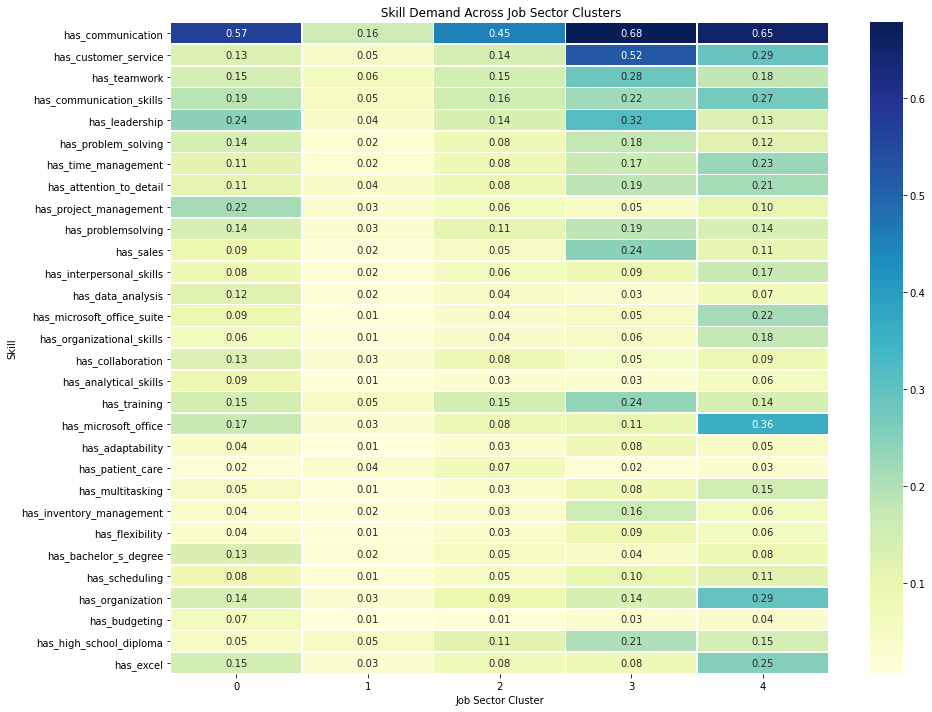


 Cluster 0 — Example Job Sectors:
Operations-Research Analyst, Film Or Videotape Editor, Archeologist, Equal Opportunity Officer, Maintenance Data Analyst, Marine Engineer, Electrician Research, Supervisor Product Inspection, Guide, Manufacturer'S Representative

 Cluster 1 — Example Job Sectors:
Layer, Hot-Room Attendant, Tester, Cardiologist, Tree Surgeon, Table Worker, Screen Writer, Salvage Engineer, Veterinarian Laboratory Animal Care, Packager Hand

 Cluster 2 — Example Job Sectors:
Reproduction Technician, Assembler, Instructor Extension Work, Bus Driver, Supervisor Packing, Development Mechanic, Porter, Supervisor Laundry, Survival Specialist, Laboratory Supervisor

 Cluster 3 — Example Job Sectors:
Preparation-Room Worker, Millwright Supervisor, Supervisor Show Operations, Service Clerk, Magazine Supervisor, Blending Supervisor, Group-Sales Representative, Kitchen Supervisor, Manager Display, Safety Manager

 Cluster 4 — Example Job Sectors:
Mail-Processing-Equipment Mechanic

In [7]:
import numpy as np
np.float = float  # Patch deprecated usage

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 1: Extract skill averages per job sector from Spark
skill_cols = [c for c in df.columns if c.startswith("has_")]

# Group by job sector (search_position) and average skill indicators
sector_skill_df = df.select("search_position", *skill_cols).na.fill(0)
sector_skill_avg = sector_skill_df.groupBy("search_position").mean()

# STEP 2: Convert to Pandas
pdf_sector = sector_skill_avg.toPandas()
pdf_sector.columns = [c.replace("avg(", "").replace(")", "") for c in pdf_sector.columns]

# STEP 3: Standardize features
X = pdf_sector[skill_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# STEP 4: Apply KMeans clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
pdf_sector["cluster"] = kmeans.fit_predict(X_scaled)

# STEP 5: Visualize as a heatmap
cluster_skill_matrix = pdf_sector.groupby("cluster")[skill_cols].mean().T

plt.figure(figsize=(14, 10))
sns.heatmap(cluster_skill_matrix, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title(" Skill Demand Across Job Sector Clusters")
plt.xlabel("Job Sector Cluster")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

# STEP 6: Optional: Print example job sectors in each cluster
for c in range(k):
    sectors = pdf_sector[pdf_sector["cluster"] == c]["search_position"].unique()
    print(f"\n Cluster {c} — Example Job Sectors:\n{', '.join(sectors[:10])}")



### Upskilling Pathway Recommendation via Cluster Similarity

This section recommends personalized upskilling paths by comparing a user's skill profile to cluster centers derived from KMeans clustering.

#### **Key Steps:**

1. **Skill Extraction**: Selects all binary skill columns (`has_` prefix) and computes a skill vector for a user with at least one skill.
2. **Cluster Center Comparison**: Retrieves KMeans cluster centers representing typical skill profiles and computes **cosine similarity** between the user and each cluster.
3. **Similarity Scoring**: Reports how similar the user is to each career cluster (0 to 1 scale).
4. **Skill Gap Analysis**:

   * For each cluster, identifies skills the user lacks but that are prevalent in that cluster.
   * Ranks missing skills by importance (i.e., their weight in the cluster center).
   * Recommends **top 5 missing skills** to move into that cluster.

#### **Why it matters:**

* Provides **actionable upskilling advice** tailored to a user's current abilities.
* Helps guide **career transitions** by showing how closely aligned a user is with other skill profiles.
* Moves beyond static rules and uses **vector similarity**, which is more flexible and scalable.


In [40]:
from pyspark.sql.functions import expr
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# 1. Define skill columns
# ----------------------------
skill_cols = [c for c in df.columns if c.startswith("has_")]

# Escape special characters for expr (e.g., apostrophes in column names)
safe_skill_expr = [f"`{c}`" for c in skill_cols]

# ----------------------------
# 2. Filter users with at least one skill
# ----------------------------
df_skilled = df.withColumn("skill_sum", expr(" + ".join(safe_skill_expr)))
sample_row = (
    df_skilled.filter("skill_sum > 0")
    .select(skill_cols)
    .limit(1)
    .collect()[0]
)
user_profile = np.array([sample_row[c] for c in skill_cols]).reshape(1, -1)

# ----------------------------
# 3. Get KMeans cluster centers
# ----------------------------
centers = model.clusterCenters()
centers_np = np.array(centers)

# ----------------------------
# 4. Compute cosine similarity between user and each cluster
# ----------------------------
sims = cosine_similarity(user_profile, centers_np).flatten()
for idx, sim in enumerate(sims):
    print(f"Similarity to Cluster {idx}: {sim:.2f}")

# ----------------------------
# 5. Recommend missing skills for each cluster
# ----------------------------
user_skills_binary = user_profile.flatten()
for i, center in enumerate(centers):
    print(f"\nTo transition into Cluster {i}, consider building these skills:")
    missing_skills = []
    for j, (user_val, center_val) in enumerate(zip(user_skills_binary, center)):
        if user_val == 0 and center_val > 0:
            missing_skills.append((skill_cols[j], center_val))
    missing_skills = sorted(missing_skills, key=lambda x: -x[1])
    for skill, weight in missing_skills[:5]:
        skill_name = skill.replace("has_", "").replace("_", " ").title()
        print(f"  - Strengthen **{skill_name}** — common in this cluster ({weight:.2f})")


Similarity to Cluster 0: 0.50
Similarity to Cluster 1: 0.17
Similarity to Cluster 2: 0.11
Similarity to Cluster 3: 0.13
Similarity to Cluster 4: 0.11

To transition into Cluster 0, consider building these skills:
  - Strengthen **Patient Care** — common in this cluster (0.09)
  - Strengthen **Leadership** — common in this cluster (0.09)
  - Strengthen **Excel** — common in this cluster (0.06)
  - Strengthen **Bachelor'S Degree** — common in this cluster (0.06)
  - Strengthen **Project Management** — common in this cluster (0.05)

To transition into Cluster 1, consider building these skills:
  - Strengthen **Customer Service** — common in this cluster (1.00)
  - Strengthen **Communication** — common in this cluster (0.79)
  - Strengthen **Sales** — common in this cluster (0.40)
  - Strengthen **Leadership** — common in this cluster (0.33)
  - Strengthen **Teamwork** — common in this cluster (0.32)

To transition into Cluster 2, consider building these skills:
  - Strengthen **Problemsol

#############################################################################################################